Hani RAFT

In [1]:
# ============================================================
# 🚀 CPU-ONLY RAFT SETUP (Using HaniKamran/RAFT Fork)
# ============================================================

import os, sys
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse

# ---------------------------
# Setup working directory and Clone your Patched Repo
# ---------------------------
os.chdir("/content")

# Install minimal dependencies
print("Installing dependencies...")
# Ensure scipy is installed correctly to avoid earlier conflicts
!pip install -q opencv-python matplotlib Pillow einops scipy

# Remove old RAFT if exists and clone YOUR FORK
!rm -rf /content/RAFT
# Cloning your specific patched branch: HaniKamran-patch-1
!git clone https://github.com/HaniKamran/RAFT.git /content/RAFT
%cd /content/RAFT
!git checkout HaniKamran-patch-1
%cd /content

# Add RAFT core modules to path
sys.path.append("/content/RAFT/core")

# ---------------------------
# Import Patched RAFT Modules
# ---------------------------
try:
    from raft import RAFT
    from utils.utils import InputPadder
    print("✓ Successfully imported core RAFT modules from your fork.")
except ImportError as e:
    print(f"FATAL ERROR: Could not import RAFT modules. Check your fork structure: {e}")
    sys.exit(1)


# ---------------------------
# Load CPU-only RAFT model
# ---------------------------
# These arguments trigger the 'small' model and disable CUDA-specific features.
# The custom logic in your raft.py will ensure the CPUCostVolume is used here.
args = argparse.Namespace(
    small=True,
    mixed_precision=False,
    alternate_corr=False, # Set to False to use the primary CorrBlock path (which you patched)
    dropout=0,
    dropout2=0,
)

weights_path = "/content/RAFT/models/raft-small.pth"

# Download weights if missing
if not os.path.exists(weights_path):
    print("Downloading RAFT weights...")
    %cd /content/RAFT
    !bash download_models.sh
    %cd /content

print("Loading RAFT CPU model...")
# Initialize model on CPU
model = RAFT(args).cpu()

# Clean state_dict and load weights
checkpoint = torch.load(weights_path, map_location="cpu")
state_dict = checkpoint.get("state_dict", checkpoint)
clean_state = {}
for k, v in state_dict.items():
    new_k = k.replace("module.", "")
    if new_k in model.state_dict():
        clean_state[new_k] = v

model.load_state_dict(clean_state, strict=False)
model.eval()
print("✓ RAFT model loaded on CPU successfully.")

# ---------------------------
# CPU-safe optical flow function
# ---------------------------
def compute_flow_debug(img1, img2, model):
    """Computes optical flow using the loaded RAFT model across various scales."""
    import matplotlib.pyplot as plt

    original_h, original_w = img1.shape[:2]
    # Use smaller scales for better CPU stability and speed
    scales = [1.0, 0.75, 0.5, 0.33, 0.25, 0.1, .01]

    for s in scales:
        try:
            print(f"\nTrying scale {s}...")
            # Ensure dimensions are at least 32x32 and multiples of 8 (padding will handle multiples of 8)
            new_h, new_w = max(32, int(original_h * s)), max(32, int(original_w * s))
            im1 = cv2.resize(img1, (new_w, new_h))
            im2 = cv2.resize(img2, (new_w, new_h))

            # Convert to tensor and normalize [0, 1]
            t1 = torch.from_numpy(im1/255.).permute(2,0,1).float().unsqueeze(0)
            t2 = torch.from_numpy(im2/255.).permute(2,0,1).float().unsqueeze(0)

            # Pad to multiples of 8 (required by RAFT architecture)
            padder = InputPadder(t1.shape)
            t1, t2 = padder.pad(t1, t2)

            print(f"Padded tensor shapes: t1={t1.shape}, t2={t2.shape}")

            # Run RAFT
            with torch.no_grad():
                # Setting iters=12 is faster for inference than the default 32
                _, flow_up = model(t1, t2, iters=12, test_mode=True)

            # Post-process flow: Resize back to original resolution (H, W)
            flow = flow_up[0].permute(1,2,0).cpu().numpy()

            # The flow values need to be scaled correctly after resizing
            flow_x = cv2.resize(flow[...,0], (original_w, original_h), interpolation=cv2.INTER_LINEAR) * (original_w / flow.shape[1])
            flow_y = cv2.resize(flow[...,1], (original_w, original_h), interpolation=cv2.INTER_LINEAR) * (original_h / flow.shape[0])
            flow_final = np.stack([flow_x, flow_y], axis=-1)

            print(f"✓ Flow computed successfully at scale {s}")
            return flow_final

        except Exception as e:
            print(f"Failed at scale {s} with error: {e}")

    raise RuntimeError("Flow failed at all scales")


print("\n✓ RAFT CPU flow ready for execution. You can now call the function.")
print('img1 = cv2.cvtColor(cv2.imread("/content/frame1.jpg"), cv2.COLOR_BGR2RGB)')
print('img2 = cv2.cvtColor(cv2.imread("/content/frame2.jpg"), cv2.COLOR_BGR2RGB)')
print('flow = compute_flow(img1, img2, model)')

Installing dependencies...
Cloning into '/content/RAFT'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 179 (delta 18), reused 0 (delta 0), pack-reused 148 (from 3)
Receiving objects: 100% (179/179), 10.03 MiB | 24.46 MiB/s, done.
Resolving deltas: 100% (75/75), done.
/content/RAFT
Branch 'HaniKamran-patch-1' set up to track remote branch 'HaniKamran-patch-1' from 'origin'.
Switched to a new branch 'HaniKamran-patch-1'
/content
✓ Successfully imported core RAFT modules from your fork.
/content/RAFT
--2025-12-06 02:57:02--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving t

In [3]:
img1 = cv2.cvtColor(cv2.imread('/content/OZOaN_5ymrc_0001.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('/content/OZOaN_5ymrc_0002.jpg'), cv2.COLOR_BGR2RGB)

flow = compute_flow_debug(img1, img2, model)
#Just comparing 2 frames took 5 mins. But only 3~4 GB in System RAM


Trying scale 1.0...
Padded tensor shapes: t1=torch.Size([1, 3, 2048, 3840]), t2=torch.Size([1, 3, 2048, 3840])


/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/RAFT/core/raft.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


✓ Flow computed successfully at scale 1.0


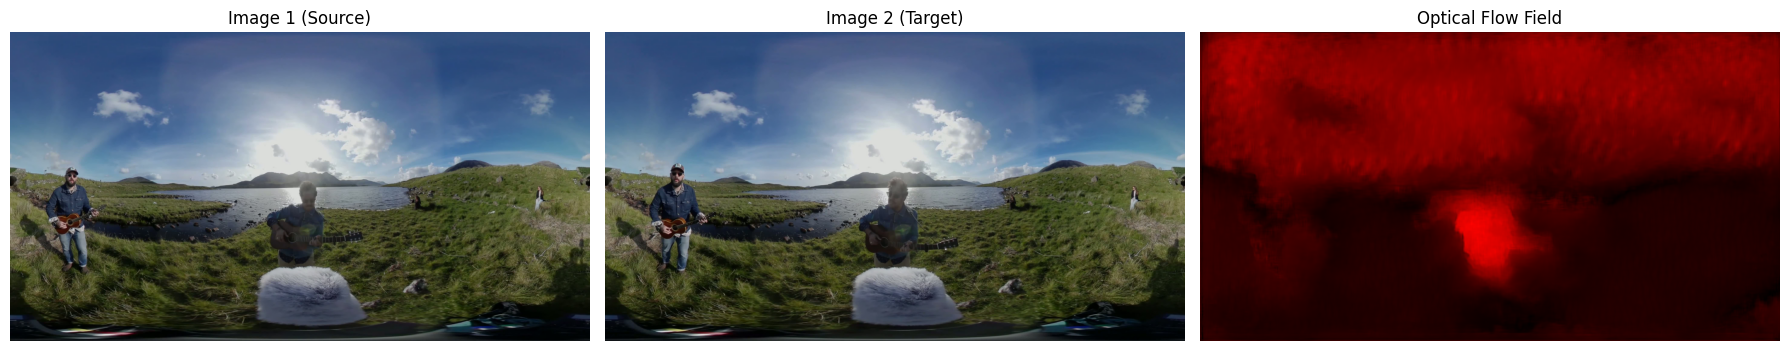

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def flow_to_image(flow):
    """
    Converts a 2-channel flow field (u, v) into an RGB image using
    the standard color wheel representation.
    """
    # 1. Extract U and V channels
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    # Get the height and width for shape matching
    H_shape, W_shape = u.shape

    # 2. Magnitude and angle calculation
    rad = np.sqrt(u**2 + v**2)
    a = np.arctan2(-v, -u) / np.pi

    # 3. Scaling
    flow_max = np.max(rad)
    if flow_max > 0:
        rad /= flow_max

    # 4. Create HSV channels
    V = rad                  # Brightness/Value = Magnitude [H x W]
    H = (a / 2 + 0.5)        # Hue = Direction [H x W]

    # FIX: Explicitly create S (Saturation) as an array of the correct shape
    S = np.ones((H_shape, W_shape), dtype=np.float32) # Saturation = 1.0 [H x W]

    # 5. Stack H, S, V and convert to RGB
    hsv = np.stack([H, S, V], axis=-1)
    rgb = cv2.cvtColor(hsv.astype(np.float32), cv2.COLOR_HSV2RGB)

    return rgb

# --- Visualization ---

# 1. Convert the flow field to a color image
flow_vis = flow_to_image(flow)

# 2. Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Image 1
axes[0].imshow(img1)
axes[0].set_title("Image 1 (Source)")
axes[0].axis('off')

# Image 2
axes[1].imshow(img2)
axes[1].set_title("Image 2 (Target)")
axes[1].axis('off')

# Optical Flow Visualization
axes[2].imshow(flow_vis)
axes[2].set_title("Optical Flow Field")
axes[2].axis('off')

plt.tight_layout()
plt.show()


# That's a very common observation when first viewing optical flow!
# When your flow visualization appears almost entirely one color (like red), it means the entire scene is dominated by movement in a single direction
# (e.g., the camera is moving forward, causing everything to move outward/backward relative to the center).

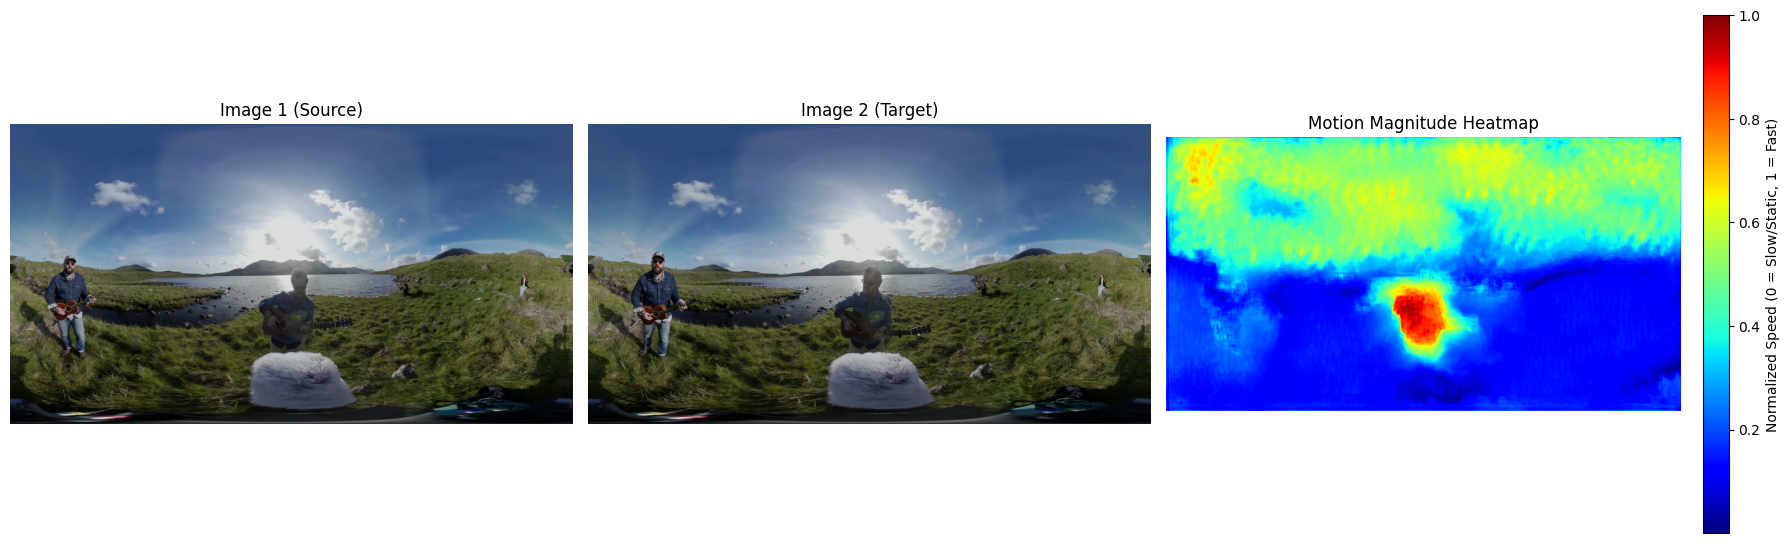

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- New Function: Converts Flow to Magnitude Array ---
def flow_to_magnitude_map(flow):
    """
    Computes only the magnitude (speed) of the optical flow.
    Returns a single-channel array where intensity corresponds to speed.
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    # Calculate magnitude: rad = sqrt(u^2 + v^2)
    rad = np.sqrt(u**2 + v**2)

    # Normalize the magnitude map to the range [0, 1]
    flow_max = np.max(rad)
    if flow_max > 0:
        rad /= flow_max

    return rad.astype(np.float32)

# 1. Compute the magnitude map
magnitude_map = flow_to_magnitude_map(flow)

# 2. Plotting the results as a heatmap

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Image 1
axes[0].imshow(img1)
axes[0].set_title("Image 1 (Source)")
axes[0].axis('off')

# Image 2
axes[1].imshow(img2)
axes[1].set_title("Image 2 (Target)")
axes[1].axis('off')

# Optical Flow Magnitude Heatmap
# We use the 'jet' colormap (Red=High, Blue=Low) for the heatmap effect
im = axes[2].imshow(magnitude_map, cmap='jet')
axes[2].set_title("Motion Magnitude Heatmap")
axes[2].axis('off')

# Add a colorbar to show the magnitude scale
cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label("Normalized Speed (0 = Slow/Static, 1 = Fast)")

plt.tight_layout()
plt.show()

#To view this motion as a heatmap, you are essentially asking to ignore the direction (color/hue)
# and only display the magnitude (speed/value) of the movement, where:
#          Hot Colors (Red/Yellow): Indicate fast movement (high flow magnitude).
#          Cool Colors (Blue/Purple): Indicate slow or no movement (low flow magnitude).